<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Weighted-Least-Squares" data-toc-modified-id="Weighted-Least-Squares-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Weighted Least Squares</a></span><ul class="toc-item"><li><span><a href="#WLS-Estimation" data-toc-modified-id="WLS-Estimation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>WLS Estimation</a></span><ul class="toc-item"><li><span><a href="#Artificial-data:-Heteroscedasticity-2-groups" data-toc-modified-id="Artificial-data:-Heteroscedasticity-2-groups-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Artificial data: Heteroscedasticity 2 groups</a></span></li><li><span><a href="#WLS-knowing-the-true-variance-ratio-of-heteroscedasticity" data-toc-modified-id="WLS-knowing-the-true-variance-ratio-of-heteroscedasticity-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>WLS knowing the true variance ratio of heteroscedasticity</a></span></li></ul></li><li><span><a href="#OLS-vs.-WLS" data-toc-modified-id="OLS-vs.-WLS-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OLS vs. WLS</a></span></li><li><span><a href="#Feasible-Weighted-Least-Squares-(2-stage-FWLS)" data-toc-modified-id="Feasible-Weighted-Least-Squares-(2-stage-FWLS)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Feasible Weighted Least Squares (2-stage FWLS)</a></span></li></ul></li></ul></div>

# Weighted Least Squares

https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/wls.ipynb

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
np.random.seed(1024)

## WLS Estimation

### Artificial data: Heteroscedasticity 2 groups 

Model assumptions:

 * Misspecification: true model is quadratic, estimate only linear
 * Independent noise/error term
 * Two groups for error variance, low and high variance groups

In [12]:
nsample = 50
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e 
X = X[:,[0,1]]
X[:4]

array([[1.        , 0.        ],
       [1.        , 0.40816327],
       [1.        , 0.81632653],
       [1.        , 1.2244898 ]])

### WLS knowing the true variance ratio of heteroscedasticity

In this example, `w` is the standard deviation of the error.  `WLS` requires that the weights are proportional to the inverse of the error variance.

In [4]:
mod_wls = sm.WLS(y, X, weights=1./(w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            WLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     613.2
Date:                Sat, 22 Jun 2019   Prob (F-statistic):           5.44e-29
Time:                        10:10:36   Log-Likelihood:                -51.136
No. Observations:                  50   AIC:                             106.3
Df Residuals:                      48   BIC:                             110.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2469      0.143     36.790      0.0

## OLS vs. WLS

Estimate an OLS model for comparison: 

In [5]:
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

[5.24256099 0.43486879]
[5.24685499 0.44658241]


Compare the WLS standard errors to  heteroscedasticity corrected OLS standard errors:

In [6]:
se = np.vstack([[res_wls.bse], [res_ols.bse], [res_ols.HC0_se], 
                [res_ols.HC1_se], [res_ols.HC2_se], [res_ols.HC3_se]])
se = np.round(se,4)
colnames = ['x1', 'const']
rownames = ['WLS', 'OLS', 'OLS_HC0', 'OLS_HC1', 'OLS_HC3', 'OLS_HC3']
tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

          x1   const 
---------------------
WLS     0.1426 0.018 
OLS     0.2707 0.0233
OLS_HC0 0.194  0.0281
OLS_HC1 0.198  0.0287
OLS_HC3 0.2003 0.029 
OLS_HC3 0.207   0.03 
---------------------


Calculate OLS prediction interval:

In [7]:
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb,X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)

In [8]:
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

Draw a plot to compare predicted values in WLS and OLS:

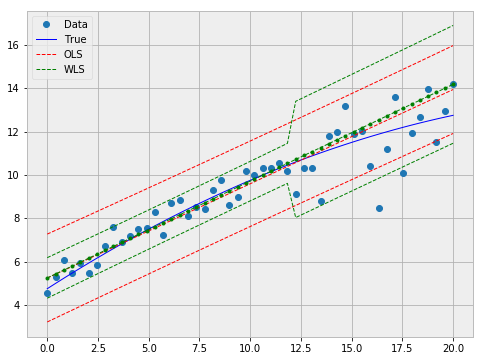

In [15]:
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
# OLS
ax.plot(x, res_ols.fittedvalues, 'r--')
ax.plot(x, iv_u_ols, 'r--', label="OLS")
ax.plot(x, iv_l_ols, 'r--')
# WLS
ax.plot(x, res_wls.fittedvalues, 'g--.')
ax.plot(x, iv_u, 'g--', label="WLS")
ax.plot(x, iv_l, 'g--')
ax.legend(loc="best");

## Feasible Weighted Least Squares (2-stage FWLS)

Like ,`w`, `w_est` is proportional to the standard deviation, and so must be squared.

In [10]:
resid1 = res_ols.resid[w==1.]
var1 = resid1.var(ddof=int(res_ols.df_model)+1)

resid2 = res_ols.resid[w!=1.]
var2 = resid2.var(ddof=int(res_ols.df_model)+1)

w_est = w.copy()
w_est[w!=1.] = np.sqrt(var2) / np.sqrt(var1)
res_fwls = sm.WLS(y, X, 1./((w_est ** 2))).fit()
print(res_fwls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            WLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     646.7
Date:                Sat, 22 Jun 2019   Prob (F-statistic):           1.66e-29
Time:                        10:10:36   Log-Likelihood:                -50.716
No. Observations:                  50   AIC:                             105.4
Df Residuals:                      48   BIC:                             109.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2363      0.135     38.720      0.0